# **import libraries and set up environments**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

import cv2
import imghdr

import tensorflow as tf
tf.random.set_seed(1234)

warnings.filterwarnings('ignore')

2024-07-11 03:59:44.592791: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 03:59:44.592910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 03:59:44.897433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# avoid OOM error by set the GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

# print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
train_path = "/kaggle/input/kain-ulos/Train"
test_path = "/kaggle/input/kain-ulos/Test"

img_classes = os.listdir(train_path)
print(f"Classes inside the dataset: {img_classes}")

Classes inside the dataset: ['Sadum', 'Ragi Hotang', 'Ragi Hidup', 'Tumtuman', 'Pinuncaan', 'Sibolang']


# **preprocessing data**

## **remove dodgy image in Training data**

In [4]:
# remove the dodgy image

img_ext = ['jpg', 'jpeg', 'bmp', 'png']

for image_class in img_classes:
    for image in os.listdir(os.path.join(train_path, image_class)):
        image_path = os.path.join(train_path, image_class, image)
        try:
            img = cv2.imread(image_path)
            format = imghdr.what(image_path)
            if format not in img_ext:
                print(f'image {image_path} format not in the list')
                print(image.index())
                os.remove(image_path)
        except Exception as e:
            print(f'there\'s issue with image {image_path}')
            # os.remove(image_path)

## **load and split dataset**

In [5]:
# define parameters
batch_size = 16
images_size = (256, 256)
val_split = 0.2
seed = 123

# Load and split the complete dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=val_split,
    subset="training",
    seed=seed,
    image_size=images_size,
    batch_size=batch_size,
    shuffle=True
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=val_split,
    subset="validation",
    seed=seed,
    image_size=images_size,
    batch_size=batch_size,
    shuffle=True
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=images_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True
)

Found 815 files belonging to 6 classes.
Using 652 files for training.
Found 815 files belonging to 6 classes.
Using 163 files for validation.
Found 416 files belonging to 6 classes.


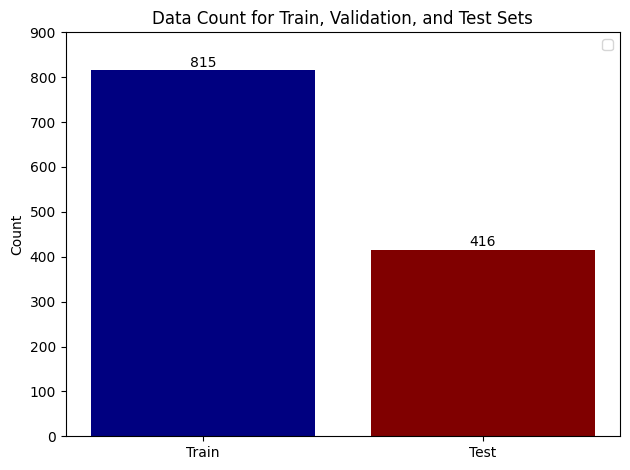

In [6]:
# Data
data_count = [815,416]
labels = ['Train', 'Test']

# Create a color map from 'inferno'
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, len(data_count)))

# Create barplot
fig, ax = plt.subplots()
bars = ax.bar(labels, data_count, color=colors)

# Add count labels on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 2, int(yval), ha='center', va='bottom')

# Set y-axis limit
ax.set_ylim(0, 900)

# Add title and labels
ax.set_title('Data Count for Train, Validation, and Test Sets')
ax.set_ylabel('Count')

# Show plot
plt.tight_layout()
plt.legend()
plt.show()

In [7]:
# train dataset
for images, labels in train_data.take(1):
    print(f"images for each batches: {labels.shape}")

images for each batches: (16,)


## **data augmentation**

In [8]:
# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.7),
    tf.keras.layers.RandomContrast(0.7),
])

In [9]:
# Apply data augmentation to the training dataset
augmented_train = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))

## **data normaization**

In [10]:
# Normalize the images
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
# Apply data normalization to the training dataset
normalized_train = augmented_train.map(lambda x, y: (normalization_layer(x), y))
normalized_val = val_data.map(lambda x, y: (normalization_layer(x), y))
normalized_test = test_data.map(lambda x, y: (normalization_layer(x), y))

In [12]:
# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
normalized_train = normalized_train.prefetch(buffer_size=AUTOTUNE)
normalized_val = normalized_val.prefetch(buffer_size=AUTOTUNE)
normalized_test = normalized_test.prefetch(buffer_size=AUTOTUNE)

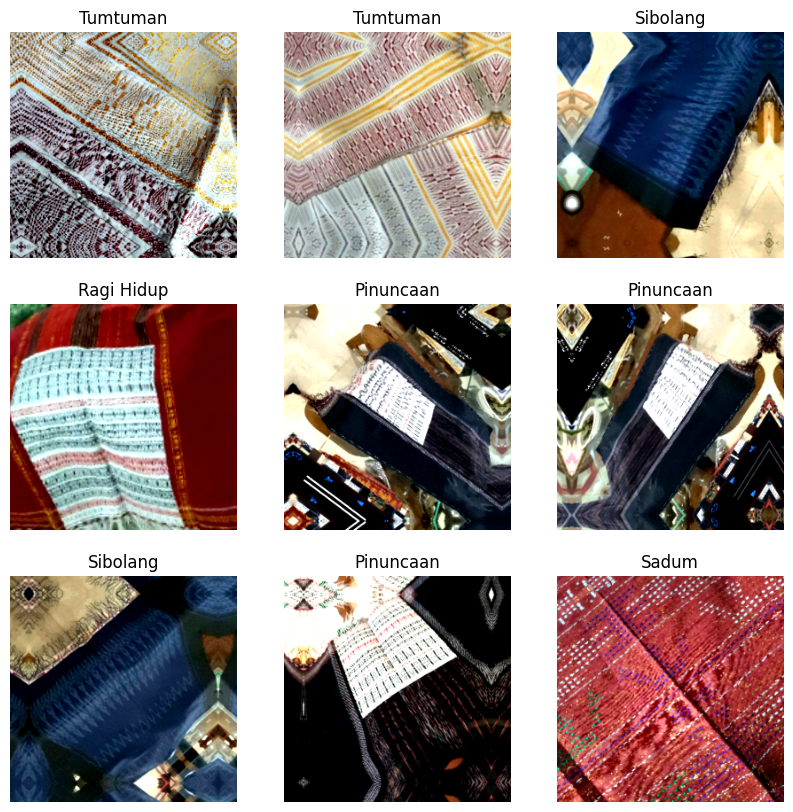

In [13]:
# Visualize some training images
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in normalized_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

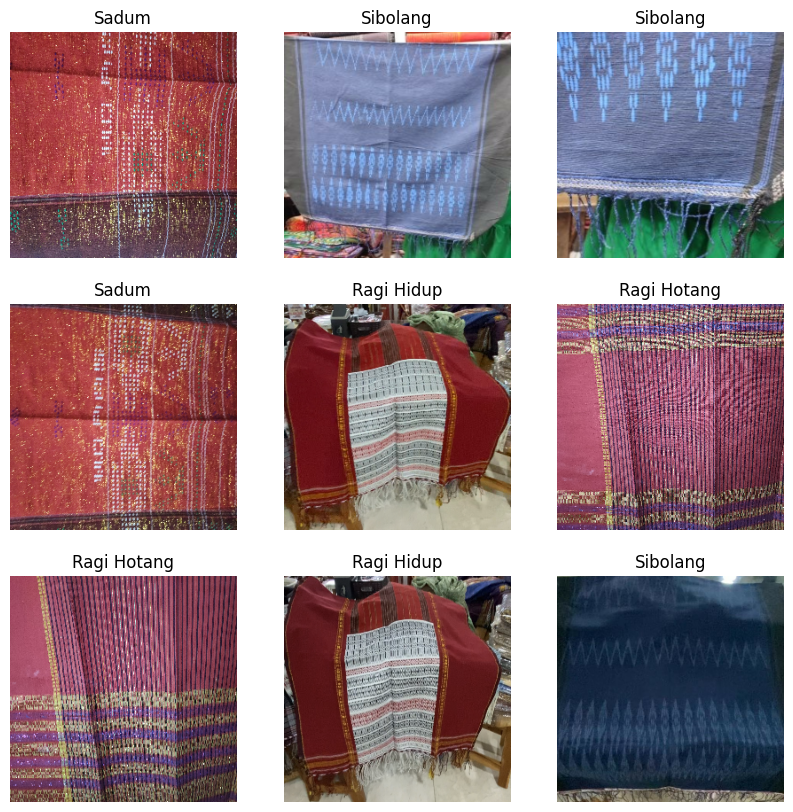

In [14]:
# Visualize some testing images
class_names = test_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in normalized_test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# **Build CNN Model**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
early_stop = tf.keras.callbacks.EarlyStopping(patience=2)

In [17]:
def ulos_model(opt, train, val):
    m = Sequential()
    m.add(Conv2D(64, (3,3), activation='relu', input_shape=(256,256,3)))
    m.add(MaxPooling2D())
    m.add(Conv2D(128, (3,3), activation='relu'))
    m.add(MaxPooling2D())
    m.add(Dropout(0.2))
    m.add(Conv2D(256, (3,3), activation='relu'))
    m.add(MaxPooling2D())
    m.add(Dropout(0.5))
    m.add(Flatten())
    m.add(Dense(128, activation='relu'))
    m.add(Dense(64, activation='relu'))
    m.add(Dense(6, activation='softmax'))
    
    # compile model
    m.compile(optimizer=opt, loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    
    # Train the model
    history = m.fit(train, validation_data=val, epochs=20, verbose=1)
    
    return history

In [18]:
Opt_adam = ulos_model(opt='adam', train=normalized_train, val=normalized_val)

Epoch 1/20
 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.1406 - loss: 2.4691  

I0000 00:00:1720626031.286296     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720626031.307119     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.3278 - loss: 1.8918

W0000 00:00:1720626062.160419     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 57s 876ms/step - accuracy: 0.3318 - loss: 1.8773 - val_accuracy: 0.5583 - val_loss: 0.8827
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 546ms/step - accuracy: 0.6993 - loss: 0.7367 - val_accuracy: 0.9325 - val_loss: 0.2654
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 556ms/step - accuracy: 0.8194 - loss: 0.4988 - val_accuracy: 0.9509 - val_loss: 0.1705
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 535ms/step - accuracy: 0.8926 - loss: 0.3277 - val_accuracy: 0.8528 - val_loss: 0.4191
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 562ms/step - accuracy: 0.8929 - loss: 0.3326 - val_accuracy: 0.9448 - val_loss: 0.1611
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 559ms/step - accuracy: 0.9072 - loss: 0.2681 - val_accuracy: 0.9877 - val_loss: 0.0826
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 545ms/step - accuracy: 0.9527 - loss: 0.1808 - val_accuracy: 0.7362 - val_loss: 0.5455
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 541ms/step - accuracy: 0.8761 - loss: 0.3838 - val_accuracy: 0.920

In [19]:
Opt_SGD = ulos_model(opt='SGD', train=normalized_train, val=normalized_val)

Epoch 1/20
 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.1406 - loss: 1.7926

W0000 00:00:1720626756.283003     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.2155 - loss: 1.7477

W0000 00:00:1720626776.281721     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 559ms/step - accuracy: 0.2170 - loss: 1.7459 - val_accuracy: 0.3926 - val_loss: 1.3877
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 545ms/step - accuracy: 0.4387 - loss: 1.4088 - val_accuracy: 0.3436 - val_loss: 1.8503
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 562ms/step - accuracy: 0.5424 - loss: 1.2654 - val_accuracy: 0.6442 - val_loss: 0.8963
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 540ms/step - accuracy: 0.6816 - loss: 0.9303 - val_accuracy: 0.8221 - val_loss: 0.6881
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 551ms/step - accuracy: 0.7170 - loss: 0.8746 - val_accuracy: 0.8098 - val_loss: 0.7393
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 546ms/step - accuracy: 0.8052 - loss: 0.6227 - val_accuracy: 0.6994 - val_loss: 1.0291
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 594ms/step - accuracy: 0.7799 - loss: 0.6896 - val_accuracy: 0.9141 - val_loss: 0.3500
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 530ms/step - accuracy: 0.8729 - loss: 0.3856 - val_accuracy: 0.766

In [20]:
Opt_RMS = ulos_model(opt='RMSprop', train=normalized_train, val=normalized_val)

Epoch 1/20
 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.2031 - loss: 7.2020

W0000 00:00:1720627241.498435     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.2377 - loss: 3.6359

W0000 00:00:1720627262.245851     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 585ms/step - accuracy: 0.2394 - loss: 3.6025 - val_accuracy: 0.6135 - val_loss: 1.0871
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 557ms/step - accuracy: 0.5320 - loss: 1.1597 - val_accuracy: 0.5951 - val_loss: 0.7646
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 549ms/step - accuracy: 0.6744 - loss: 0.7327 - val_accuracy: 0.6442 - val_loss: 1.4410
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 543ms/step - accuracy: 0.8357 - loss: 0.5086 - val_accuracy: 0.9693 - val_loss: 0.1509
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 544ms/step - accuracy: 0.9216 - loss: 0.2877 - val_accuracy: 0.9448 - val_loss: 0.1967
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 539ms/step - accuracy: 0.9253 - loss: 0.2926 - val_accuracy: 0.9816 - val_loss: 0.1061
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 549ms/step - accuracy: 0.9117 - loss: 0.2687 - val_accuracy: 0.9325 - val_loss: 0.1628
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 555ms/step - accuracy: 0.9104 - loss: 0.2522 - val_accuracy: 0.987

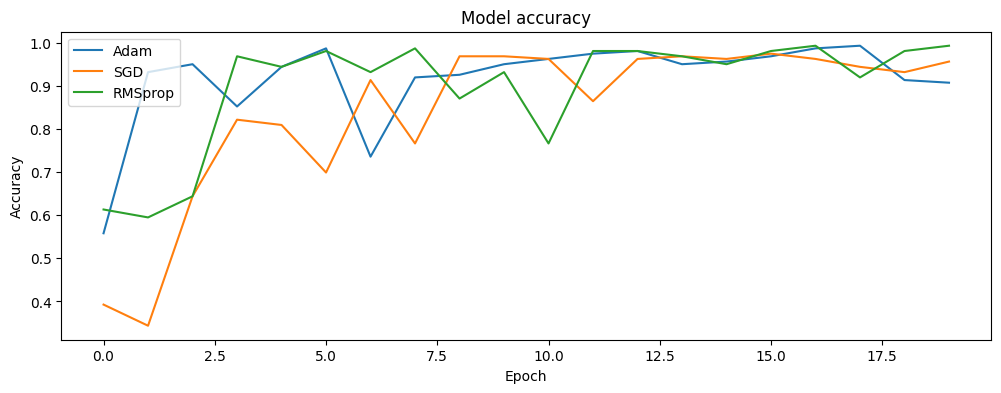

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.plot(Opt_adam.history['val_accuracy'])
plt.plot(Opt_SGD.history['val_accuracy'])
plt.plot(Opt_RMS.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Adam', 'SGD', 'RMSprop'], loc='upper left')
plt.show()

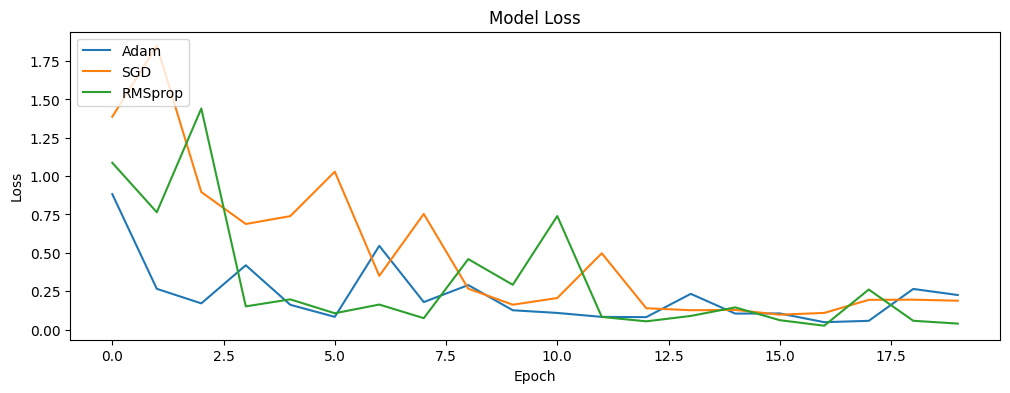

In [24]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.plot(Opt_adam.history['val_loss'])
plt.plot(Opt_SGD.history['val_loss'])
plt.plot(Opt_RMS.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Adam', 'SGD', 'RMSprop'], loc='upper left')
plt.show()

In [16]:
m = Sequential()

# input layer
m.add(Conv2D(64, (3,3), activation='relu', input_shape=(256,256,3)))
m.add(MaxPooling2D())

# second layer
m.add(Conv2D(128, (3,3), activation='relu'))
m.add(MaxPooling2D())
m.add(Dropout(0.2))

# third layer
m.add(Conv2D(256, (3,3), activation='relu'))
m.add(MaxPooling2D())
m.add(Dropout(0.5))

m.add(Flatten())

m.add(Dense(128, activation='relu'))
m.add(Dense(64, activation='relu'))
m.add(Dense(6, activation='softmax'))

In [17]:
m.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    29,491,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,870,790 (113.95 MB)

 Trainable params: 29,870,790 (113.95 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# compile model
m.compile(optimizer='SGD', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [19]:
# Train the model
history = m.fit(normalized_train, validation_data=normalized_val, epochs=50, verbose=1)

Epoch 1/50
 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.2344 - loss: 1.7832  

I0000 00:00:1720670502.856952     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720670502.877645     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.2099 - loss: 1.7534

W0000 00:00:1720670534.036593     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 55s 885ms/step - accuracy: 0.2117 - loss: 1.7515 - val_accuracy: 0.3681 - val_loss: 1.4316
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 572ms/step - accuracy: 0.3840 - loss: 1.4809 - val_accuracy: 0.3006 - val_loss: 1.6300
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 577ms/step - accuracy: 0.5365 - loss: 1.1895 - val_accuracy: 0.7301 - val_loss: 0.9356
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 579ms/step - accuracy: 0.6860 - loss: 0.9385 - val_accuracy: 0.8344 - val_loss: 0.6076
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 560ms/step - accuracy: 0.7501 - loss: 0.6575 - val_accuracy: 0.5399 - val_loss: 1.2397
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 566ms/step - accuracy: 0.7281 - loss: 0.7623 - val_accuracy: 0.9264 - val_loss: 0.3019
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 563ms/step - accuracy: 0.8674 - loss: 0.3966 - val_accuracy: 0.8098 - val_loss: 0.4279
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 588ms/step - accuracy: 0.8785 - loss: 0.3244 - val_accuracy: 0.674

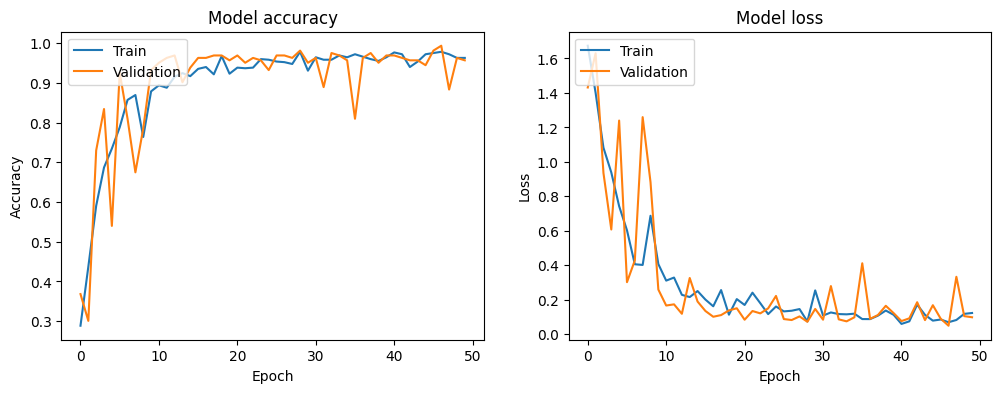

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


W0000 00:00:1720671772.195611     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<Figure size 1000x800 with 0 Axes>

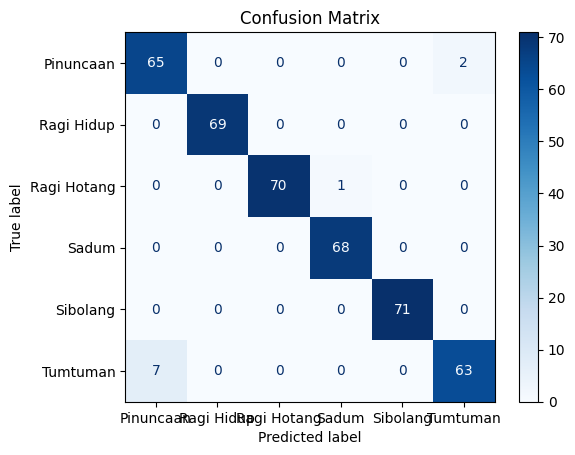

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to extract labels and predictions
def get_labels_and_predictions(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Get true labels and predictions
y_true, y_pred = get_labels_and_predictions(m, normalized_test)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94        67
           1       1.00      1.00      1.00        69
           2       1.00      0.99      0.99        71
           3       0.99      1.00      0.99        68
           4       1.00      1.00      1.00        71
           5       0.97      0.90      0.93        70

    accuracy                           0.98       416
   macro avg       0.98      0.98      0.98       416
weighted avg       0.98      0.98      0.98       416



In [23]:
print(f"The accuracy: {np.round(m.evaluate(normalized_test)[1]*100,2)}%, with loss: {m.evaluate(normalized_test)[0]}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.9692 - loss: 0.0562
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - accuracy: 0.9645 - loss: 0.0649
The accuracy: 97.6%, with loss: 0.05438319966197014


In [24]:
# MODEL 3 = Complete 1200 data
# Export your model to the SavedModel format
m.save("CNN_Ulos_Classification_04.h5")